title: "R Notebook"
output: html_notebook

In [1]:
library(quantmod)
library(xts)
library(rumidas)
library(xts)
library(rugarch)


Warning message:
"package 'quantmod' was built under R version 4.3.3"
Loading required package: xts

Warning message:
"package 'xts' was built under R version 4.3.3"
Loading required package: zoo

Warning message:
"package 'zoo' was built under R version 4.3.3"

Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric


Loading required package: TTR

Warning message:
"package 'TTR' was built under R version 4.3.3"
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Warning message:
"package 'rumidas' was built under R version 4.3.3"
Loading required package: maxLik

Warning message:
"package 'maxLik' was built under R version 4.3.3"
Loading required package: miscTools

Warning message:
"package 'miscTools' was built under R version 4.3.3"

Please cite the 'maxLik' package as:
Henningsen, Arne and Toomet, Ott (2011). maxLik: A package for maximum likelihood estimation in R. Computational

## Read datasets

### Google data

In [2]:
google_data <- read.csv("google_data.csv", header = TRUE, stringsAsFactors = FALSE)


In [3]:
### Vestas stock price data

In [4]:

symbol <- "VWS.CO"  # Vestas Wind Systems (Copenhagen Stock Exchange)
start_date <- as.Date("2010-01-01")
end_date <- as.Date("2022-08-31")
getSymbols(symbol, src = "yahoo", from = start_date, to = end_date)
vestas_data <- Cl(get(symbol))  # Cl() extracts the closing prices
vestas_df <- data.frame(date = index(vestas_data), price = coredata(vestas_data))


[1] "VWS.CO"

## Clean and prepare the data

### Google data


In [5]:

# Select only the relevant columns
google_data <- google_data[, c("country", "countryISO", "techSector", "year", "value")]

# Define the sectors you're interested in
tech_sectors <- c("Batteries", "Electric vehicle", "Electricity", "Electrification", 
                  "Geothermal", "Heat pump", "Hydroelectricity", "Hydrogen", 
                  "Nuclear", "Offshore wind", "Solar power", "Train", "Wind power")

# Filter for the selected tech sectors
google_data <- google_data[google_data$techSector %in% tech_sectors, ]

colnames(google_data)[colnames(google_data) == "year"] <- "date"

# Convert the date column into a proper date format
google_data$date <- as.Date(paste0(substr(google_data$date, 1, 2), 
                                   "-", substr(google_data$date, 3, 4), 
                                   "-01"), 
                            format = "%y-%m-%d")
# Convert back to Date type
google_data$date <- as.Date(google_data$date)

# Aggregate: Compute average value for each month
google_monthly_avg <- aggregate(value ~ date, data = google_data, FUN = mean)

head(google_monthly_avg)


,date,value
,<date>,<dbl>
1,2010-01-01,4.682794
2,2010-02-01,4.591593
3,2010-03-01,4.745969
4,2010-04-01,4.914769
5,2010-05-01,4.848954
6,2010-06-01,4.842765


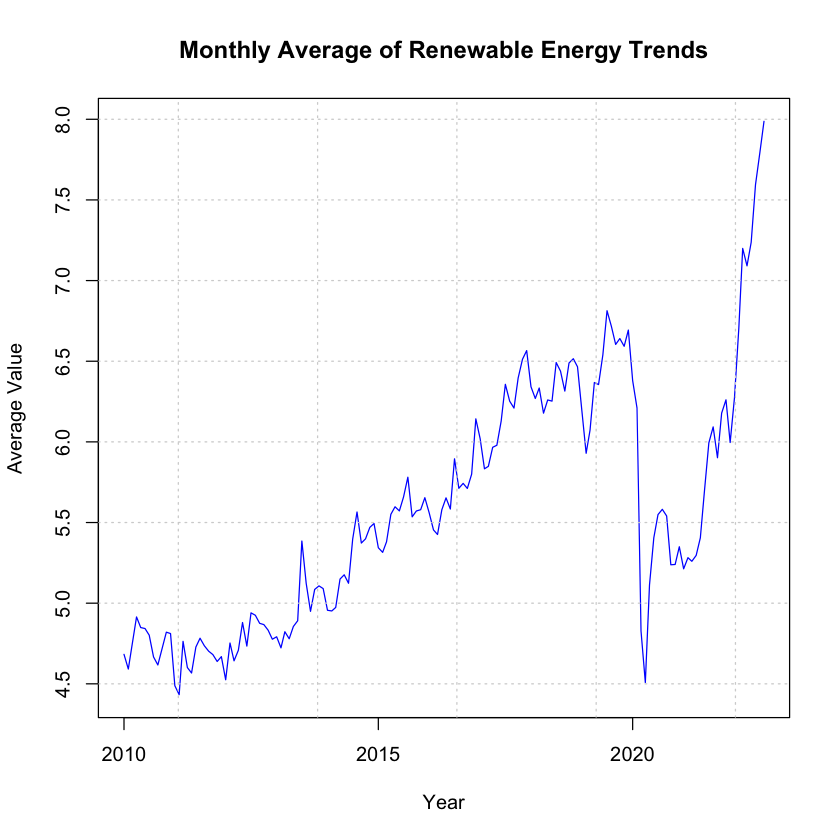

In [6]:

# Plot the monthly average values
plot(google_monthly_avg$date, google_monthly_avg$value, type = "l", col = "blue",
     xlab = "Year", ylab = "Average Value", main = "Monthly Average of Renewable Energy Trends")

# Add grid for better readability
grid()


### Vestas stock price data

In [7]:

# Rename the column for easier access
colnames(vestas_df)[2] <- "price"
vestas_df$date <- as.Date(vestas_df$date)



vestas_df


date,price
<date>,<dbl>
2010-01-04,66.40
2010-01-05,64.38
2010-01-06,63.58
2010-01-07,64.10
2010-01-08,63.80
2010-01-11,65.80
2010-01-12,63.40
2010-01-13,65.40
2010-01-14,66.80


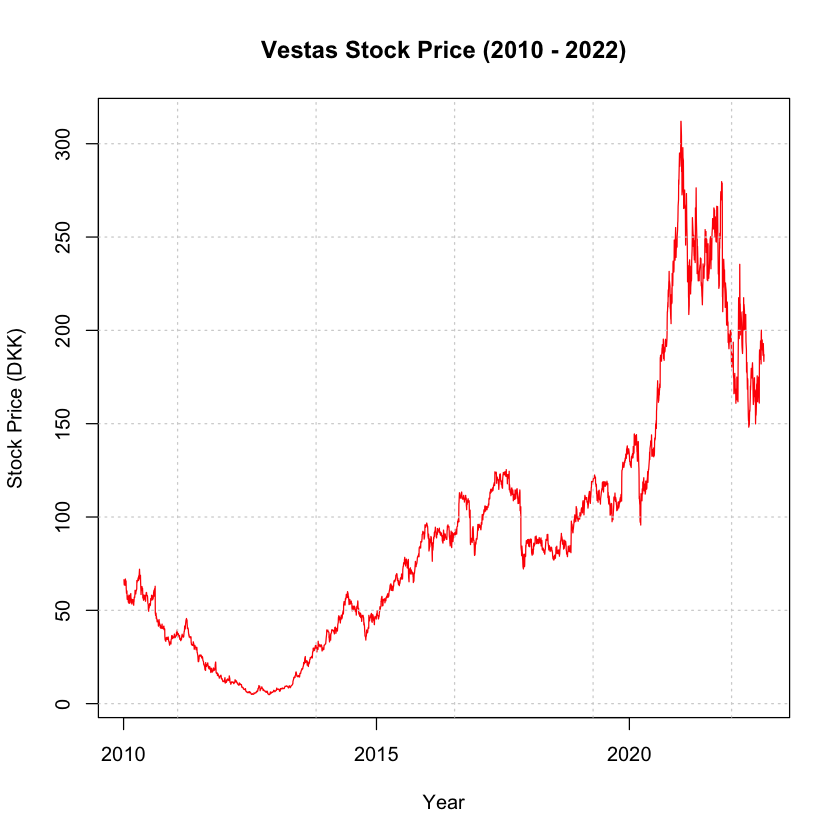

In [8]:

# Plot Vestas stock price over time
plot(vestas_df$date, vestas_df$price, type = "l", col = "red",
     xlab = "Year", ylab = "Stock Price (DKK)", 
     main = "Vestas Stock Price (2010 - 2022)")
# Add grid for better readability
grid()


,date,log_return
,<date>,<dbl>
1,2010-01-05,-0.030894096
2,2010-01-06,-0.012503999
3,2010-01-07,0.008145356
4,2010-01-08,-0.004691162
5,2010-01-11,0.030866706
6,2010-01-12,-0.037155999


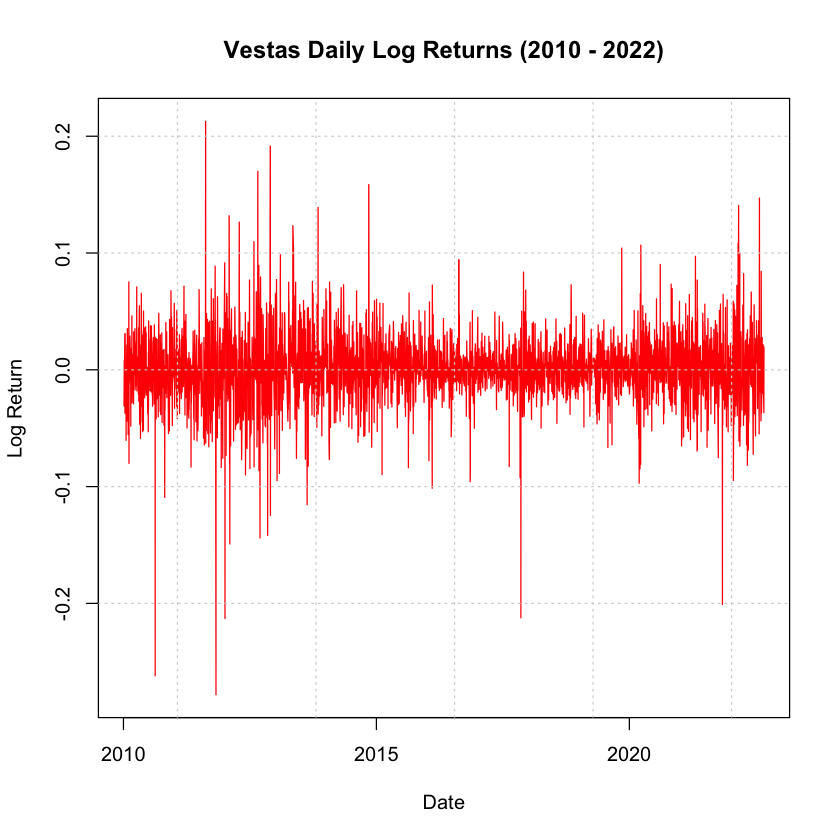

In [9]:

# Calculate the log returns (difference of log prices)
vestas_daily_returns <- diff(log(vestas_df$price))

# Create a new data frame with the corresponding dates and returns
vestas_returns_df <- data.frame(date = vestas_df$date[-1], log_return = vestas_daily_returns)

# View the data frame
head(vestas_returns_df)

# Plot the log returns over time
plot(vestas_returns_df$date, vestas_returns_df$log_return, type = "l", col = "red", 
     xlab = "Date", ylab = "Log Return", 
     main = "Vestas Daily Log Returns (2010 - 2022)")

# Add grid for better readability
grid()




## Transfrom data to xts

### Google data


In [10]:

google_monthly_avg_xts <- xts(google_monthly_avg$value, order.by = google_monthly_avg$date)
colnames(google_monthly_avg_xts) <- "value"
head(google_monthly_avg_xts)

              value
2010-01-01 4.682794
2010-02-01 4.591593
2010-03-01 4.745969
2010-04-01 4.914769
2010-05-01 4.848954
2010-06-01 4.842765

### Vestas log return data

In [11]:

vestas_daily_returns_xts <- xts(vestas_returns_df$log_return, order.by = vestas_returns_df$date)
colnames(vestas_daily_returns_xts) <- "return"
head(vestas_daily_returns_xts)


                 return
2010-01-05 -0.030894096
2010-01-06 -0.012503999
2010-01-07  0.008145356
2010-01-08 -0.004691162
2010-01-11  0.030866706
2010-01-12 -0.037155999

## Garch-Midas

### Alignment of dates 

In [12]:

K_value <- 8

# Identify the starting date of the monthly data
start_monthly <- index(google_monthly_avg_xts)[1]

# Add K months to the starting date
new_start_date <- as.Date(seq(start_monthly, by = "month", length.out = K_value + 1)[K_value + 1])

# Adjust the daily data to start from the new date only if needed
if (index(vestas_daily_returns_xts)[1] < new_start_date) {
  vestas_daily_returns_xts <- vestas_daily_returns_xts[new_start_date <= index(vestas_daily_returns_xts)]
}

# Ensure the end date of daily data doesn't exceed the end date of monthly data
end_monthly <- index(google_monthly_avg_xts)[length(google_monthly_avg_xts)]
if (index(vestas_daily_returns_xts)[length(vestas_daily_returns_xts)] > end_monthly) {
  vestas_daily_returns_xts <- vestas_daily_returns_xts[index(vestas_daily_returns_xts) <= end_monthly]
}

head(vestas_daily_returns_xts)
tail(vestas_daily_returns_xts)

head(google_monthly_avg_xts)
tail(google_monthly_avg_xts)


                  return
2010-09-01  0.0261158436
2010-09-02 -0.0152264542
2010-09-03  0.0004511721
2010-09-06  0.0004509686
2010-09-07 -0.0127043763
2010-09-08 -0.0045766846

                 return
2022-07-25 -0.026408836
2022-07-26 -0.054882575
2022-07-27 -0.001613264
2022-07-28  0.147100150
2022-07-29  0.015847159
2022-08-01 -0.019068416

              value
2010-01-01 4.682794
2010-02-01 4.591593
2010-03-01 4.745969
2010-04-01 4.914769
2010-05-01 4.848954
2010-06-01 4.842765

              value
2022-03-01 7.199471
2022-04-01 7.091201
2022-05-01 7.237643
2022-06-01 7.594575
2022-07-01 7.784825
2022-08-01 7.987226

## Fitting the model

In [13]:

dist_GM <- "std"
chosen_weighting_function <- "Beta"

mv_m <- mv_into_mat(x = vestas_daily_returns_xts$return , mv = google_monthly_avg_xts, K = K_value, type = "monthly")

GM <- ugmfit(
    model = "GM",
    skew = "NO",
    distribution = dist_GM,
    daily_ret = vestas_daily_returns_xts$return ,
    mv_m = mv_m,
    K = K_value, 
    lag_fun = chosen_weighting_function
)

GM
summary.rumidas(GM)
names(GM)
print(GM$loglik)
print(GM$inf_criteria)




Model: GM 

Coefficients: 
alpha     beta      m         theta     w2        shape     
0.0423    0.9445    -3.6047   -0.6083   1.001     4.0049    



Coefficients:
      Estimate Std. Error  t value Pr(>|t|) Sig.
alpha   0.0423     0.0166   2.5552   0.0106   **
beta    0.9445     0.0244  38.6836   0.0000  ***
m      -3.6047     0.0923 -39.0463   0.0000  ***
theta  -0.6083     0.0303 -20.0696   0.0000  ***
w2      1.0010     0.0669  14.9675   0.0000  ***
shape   4.0049     0.0769  52.0824   0.0000  ***
--- 
Signif. codes: 0.01 '***', 0.05 '**', 0.1 '*' 

Obs.: 2975. Sample Period: 2010-09-01/2022-08-01 
MSE(%): 0.00082;  QLIKE: -6.16794 



[1] "model"        "rob_coef_mat" "obs"          "period"       "loglik"      
[6] "inf_criteria" "loss_in_s"    "est_vol_in_s" "est_lr_in_s"

[1] 8385.955
      AIC       BIC 
-16759.91 -16723.92 
